### DESEQ2 analysis of Hydrogel dataset: Mammary glands vs 2D Soft vs 2D TCPS vs 3D Soft 

1 Factor design: 

* Sample :  100Pa3D, 2DSoft, 2DTCPS, Mamgland

* 52,977 idr peaks 
* 3 biological replicates per Sample (except 2 for Mamgland) 

* Using SVA

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [8]:
#load ATAC-seq raw read counts
data=read.table('mamgland.idr.atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL



In [9]:
head(data)
print(nrow(data))

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2D_soft_Rep1,X2D_soft_Rep2,X2D_soft_Rep3,X2D_TCPS_Rep1,X2D_TCPS_Rep2,X2D_TCPS_Rep3,mamgland_Rep1,mamgland_Rep2
chr1_713708_714452,6,11,7,50,49,62,2,3,4,113,51
chr1_804992_805589,2,6,1,21,12,13,0,0,0,34,10
chr1_846336_846857,16,22,14,47,24,48,4,7,10,12,5
chr1_859087_859364,6,9,6,12,5,13,4,0,1,20,10
chr1_868304_868768,10,9,2,18,2,18,1,2,2,26,13
chr1_894444_894853,6,2,7,26,18,23,0,4,2,43,15


[1] 52976


In [10]:
#load the metadata
batches=read.table("batches_mamgland.txt",header=TRUE,sep='\t',row.names=1)
batches$Sample=factor(batches$Sample)


In [11]:
batches

,Sample
X100Pa_3D_Rep1,100Pa3D
X100Pa_3D_Rep2,100Pa3D
X100Pa_3D_Rep3,100Pa3D
X2D_soft_Rep1,2DSoft
X2D_soft_Rep2,2DSoft
X2D_soft_Rep3,2DSoft
X2D_TCPS_Rep1,2DTCPS
X2D_TCPS_Rep2,2DTCPS
X2D_TCPS_Rep3,2DTCPS
mamgland_Rep1,Mamgland


In [18]:
data=data+1

## SVA analysis

In [20]:
data=data[rowSums(data)>0,]
mod0=model.matrix(~1,data=batches)
mod1=model.matrix(~0+Sample,data=batches)
sva.obj=svaseq(as.matrix(data),mod1,mod0,method='irw')
sur_var=data.frame(sva.obj$sv)
names(sur_var)=c("sv1")
batches=cbind(batches,sur_var)


Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  

In [21]:
#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~0+Sample+sv1)


converting counts to integer mode
  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function


## Differential Accessibility Operation

In [22]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


## Extract and store normalized counts for further analysis 

In [23]:
normcounts=counts(dds,normalized=TRUE)
#use limma's removeBatchEffect function 
tokeep=model.matrix(~Sample,data=batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(batches,select=c("sv1")))



write.table(normcounts,"normcounts_from_deseq_with_SVA.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [24]:
vsd=assay(vst(dds,blind=FALSE))
rld=assay(rlog(dds,blind=FALSE))
ntd <- assay(normTransform(dds))

In [25]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2D_soft_Rep1,X2D_soft_Rep2,X2D_soft_Rep3,X2D_TCPS_Rep1,X2D_TCPS_Rep2,X2D_TCPS_Rep3,mamgland_Rep1,mamgland_Rep2
chr1_713708_714452,10.432786,10.486028,10.379545,25.915245,32.640921,30.216940,7.528880,9.341036,13.643547,36.678621,28.362871
chr1_804992_805589,4.355868,6.116850,2.594886,11.179125,8.486639,6.714876,2.509627,2.335259,2.728709,11.260980,5.999838
chr1_846336_846857,19.779933,20.098221,19.461646,24.390819,16.320461,23.502064,12.548134,18.682073,30.015804,4.182650,3.272639
chr1_859087_859364,8.910229,8.738357,9.082102,6.605847,3.916911,6.714876,12.548134,2.335259,5.457419,6.756588,5.999838
chr1_868304_868768,6.315343,8.738357,3.892329,9.654699,1.958455,9.113045,5.019254,7.005777,8.186128,8.687042,7.636158
chr1_894444_894853,6.500526,2.621507,10.379545,13.719835,12.403550,11.511215,2.509627,11.676295,8.186128,14.156661,8.727037


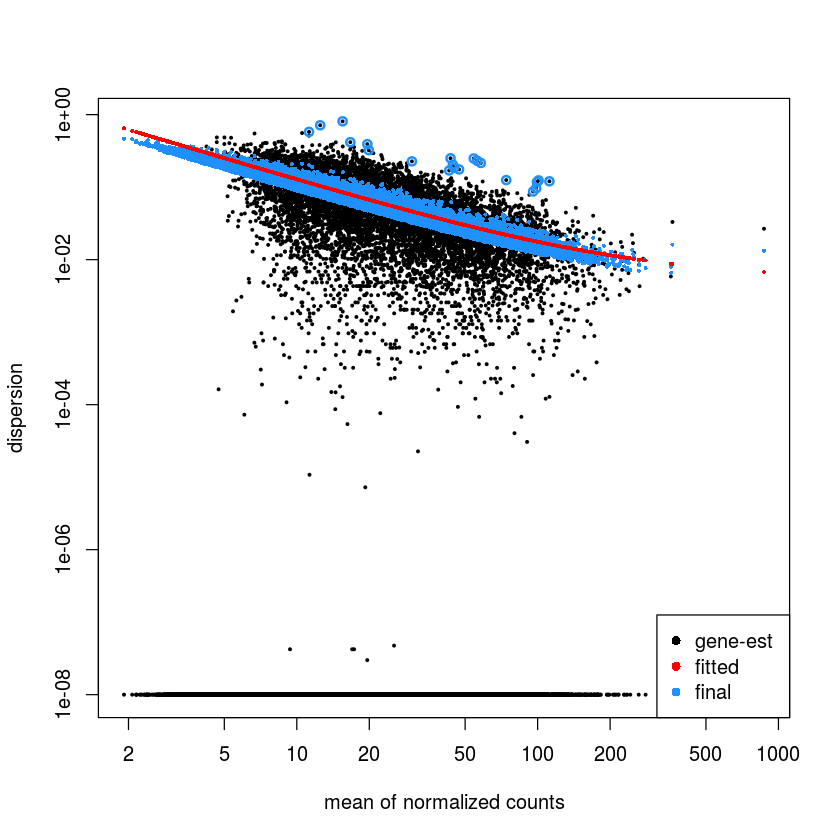

In [26]:
plotDispEsts(dds)

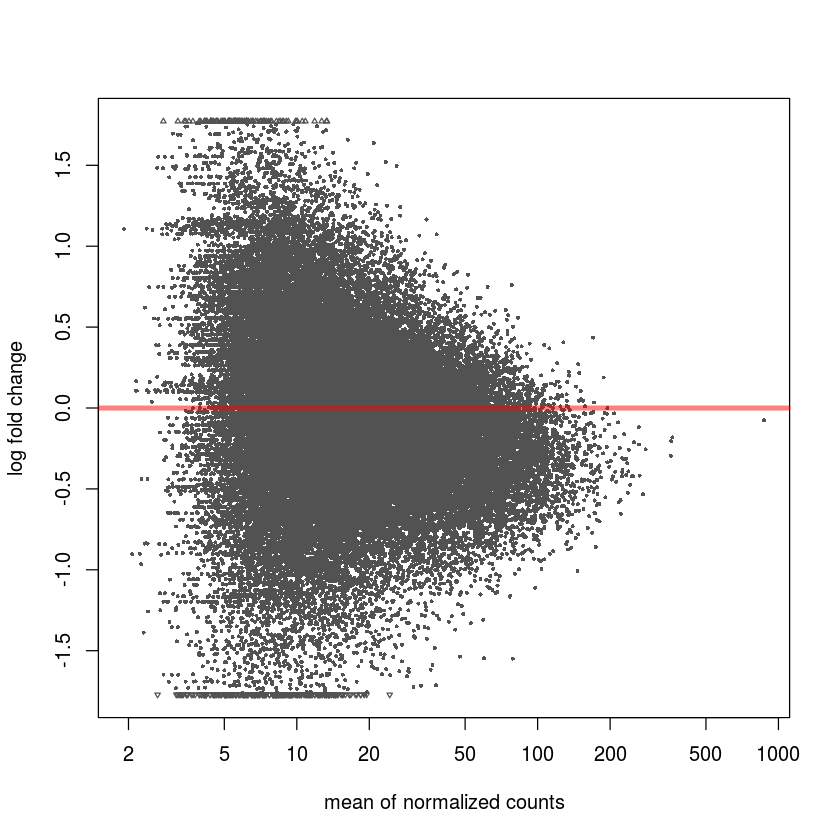

In [27]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [28]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

[1] 7059


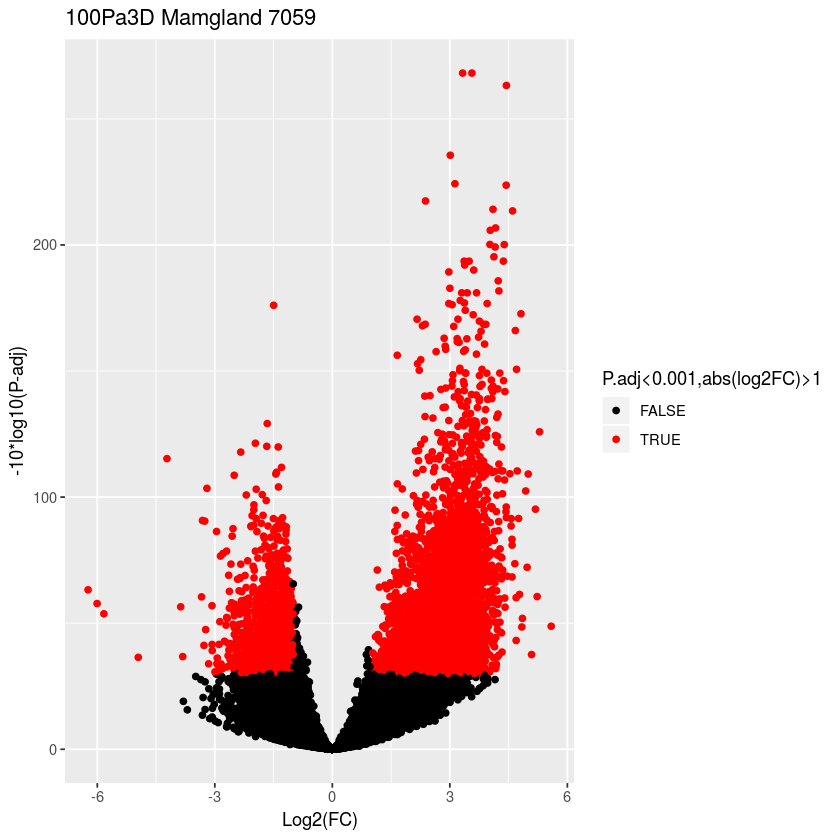

[1] 8471


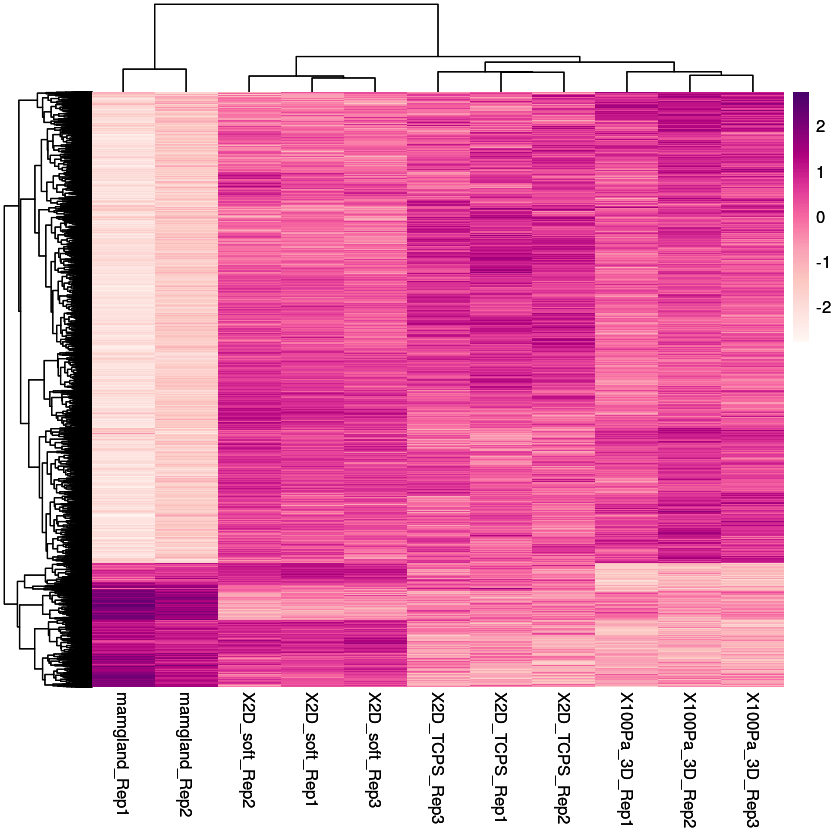

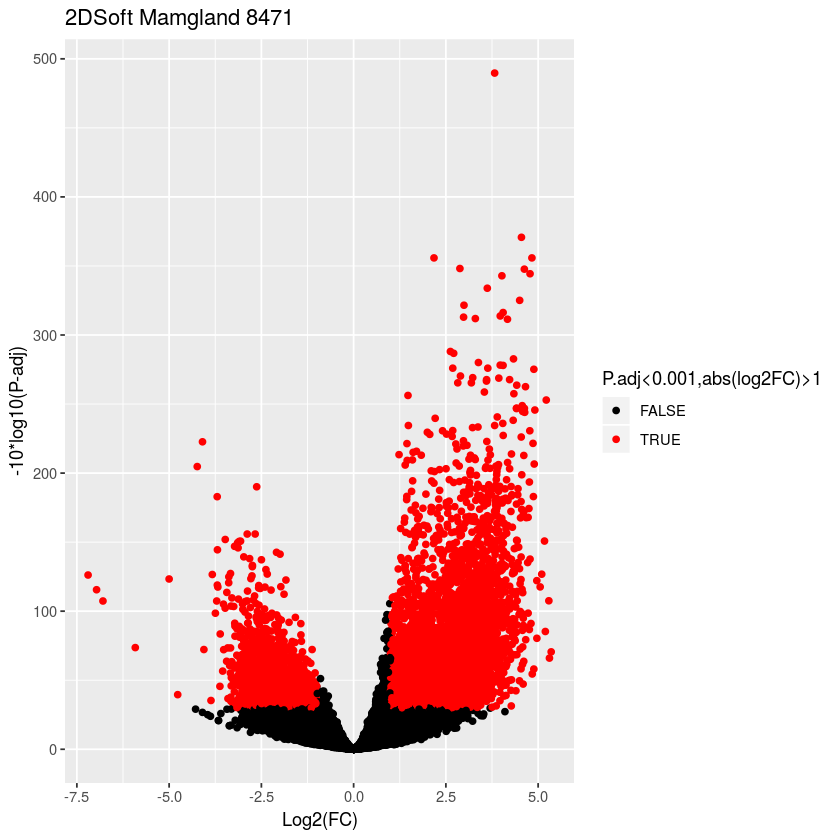

[1] 8007


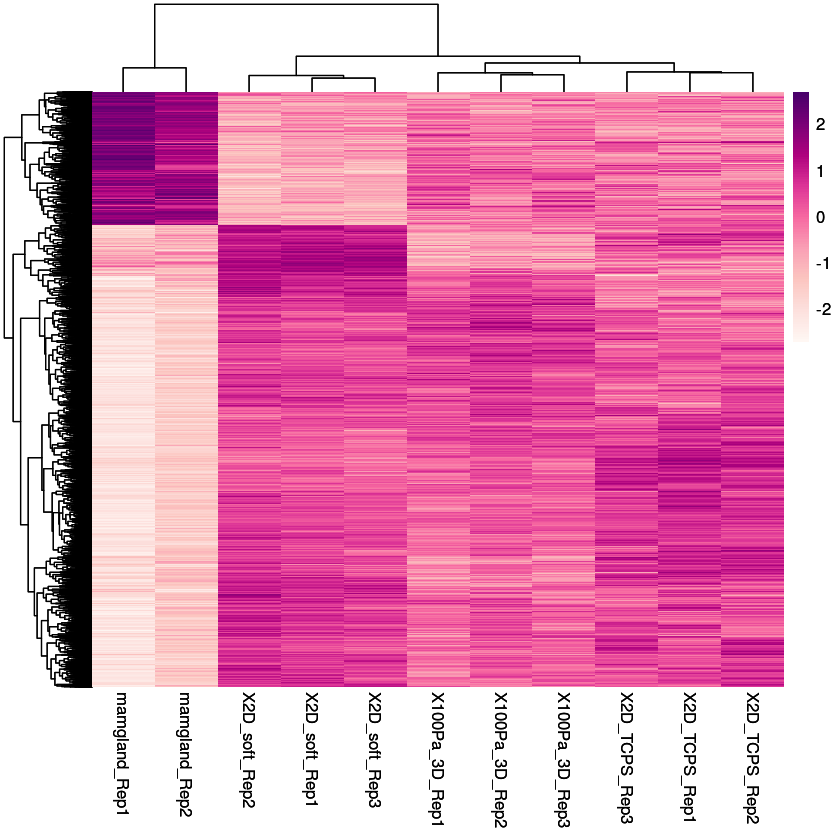

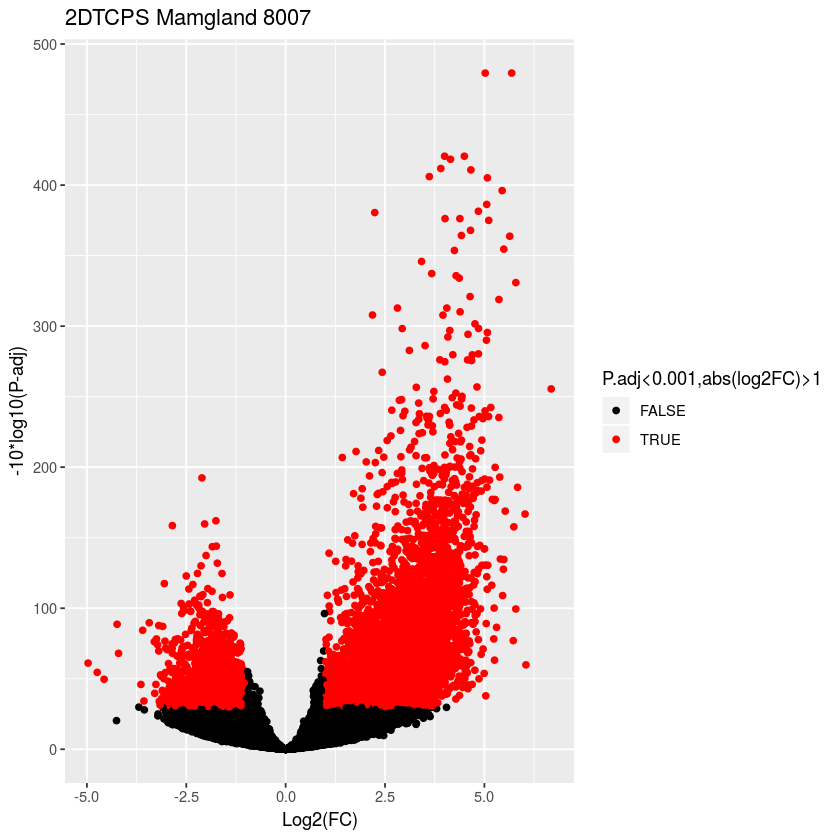

[1] 1318


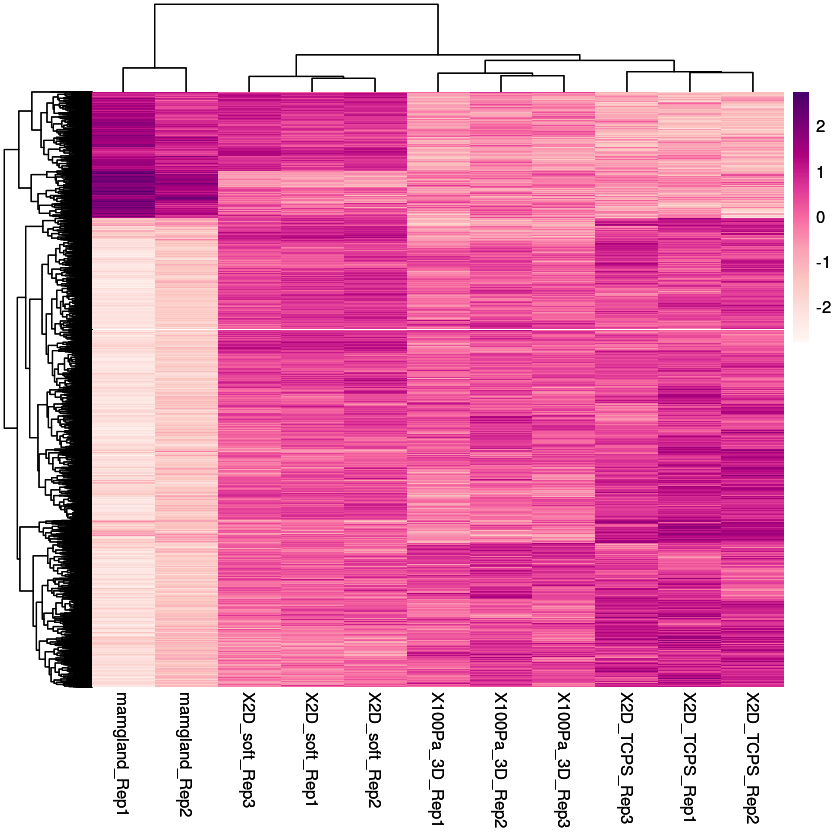

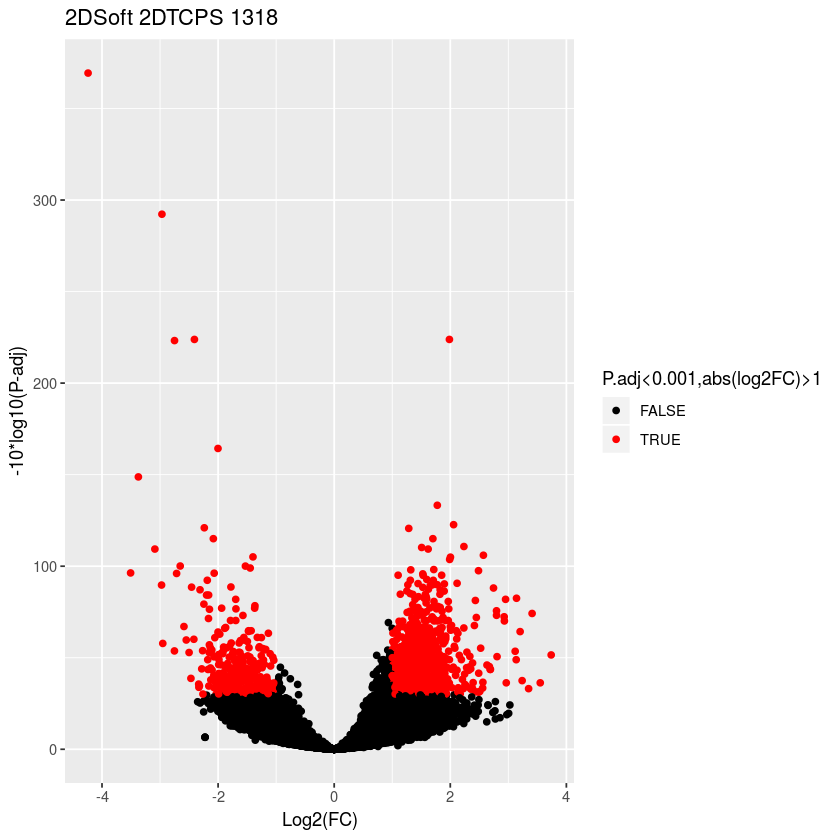

[1] 1947


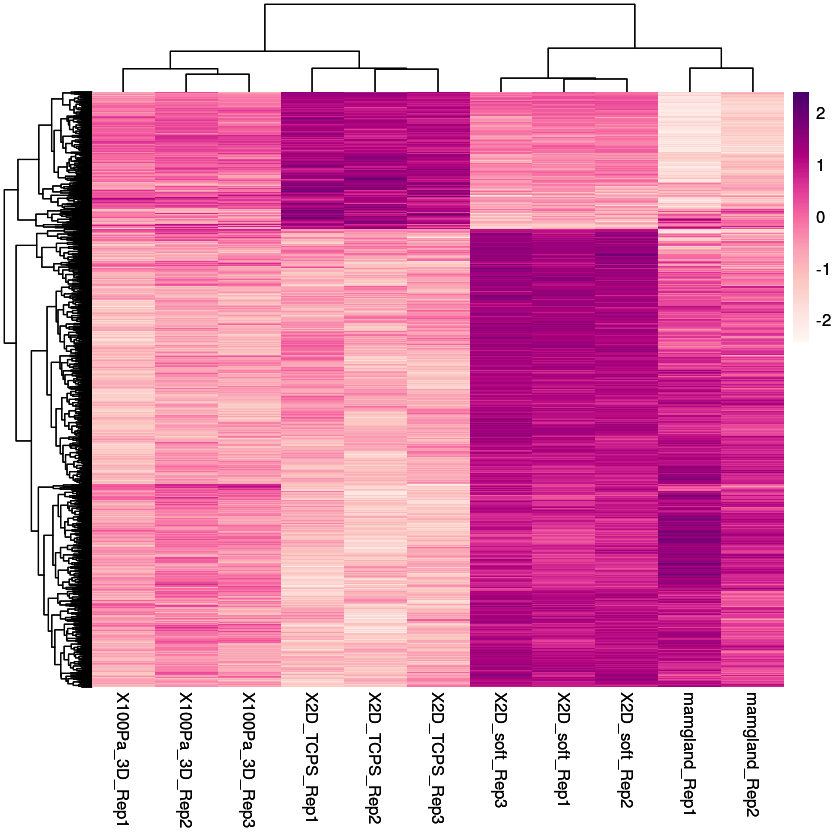

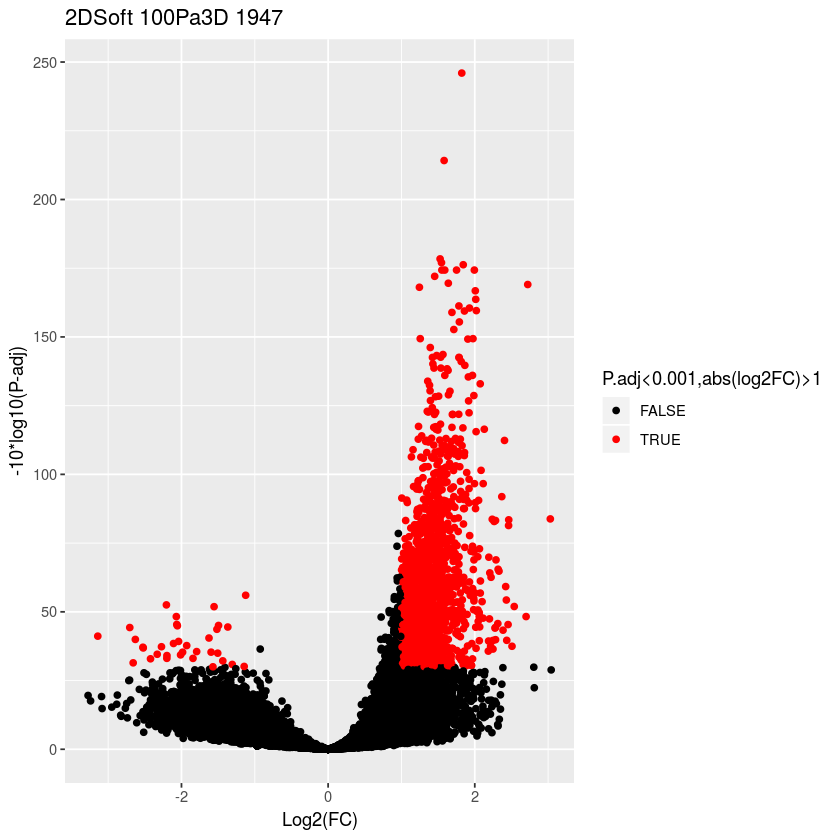

[1] 423


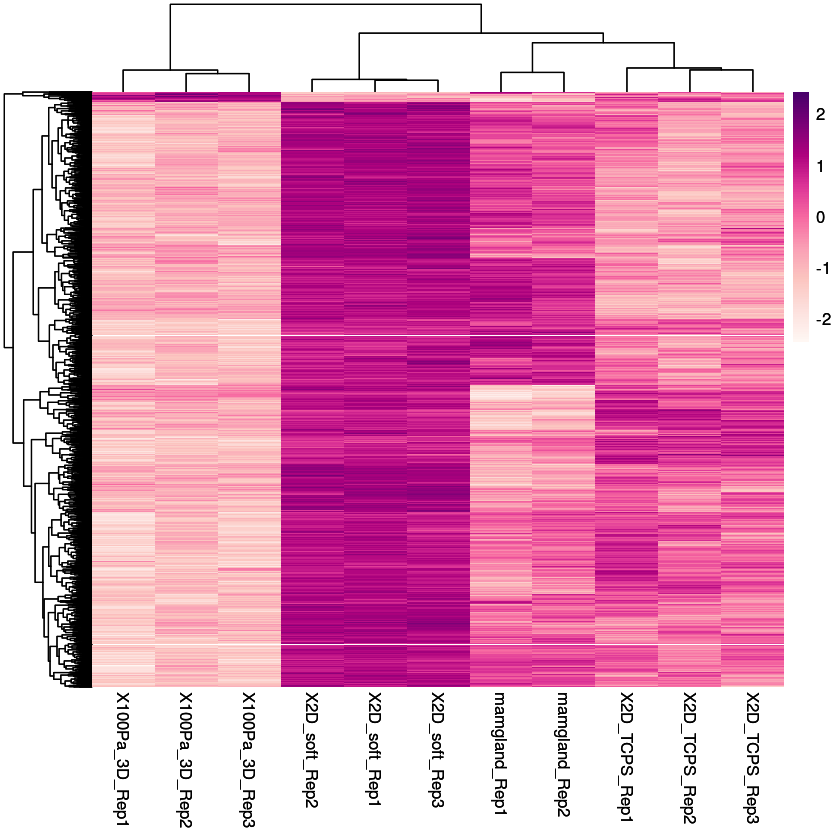

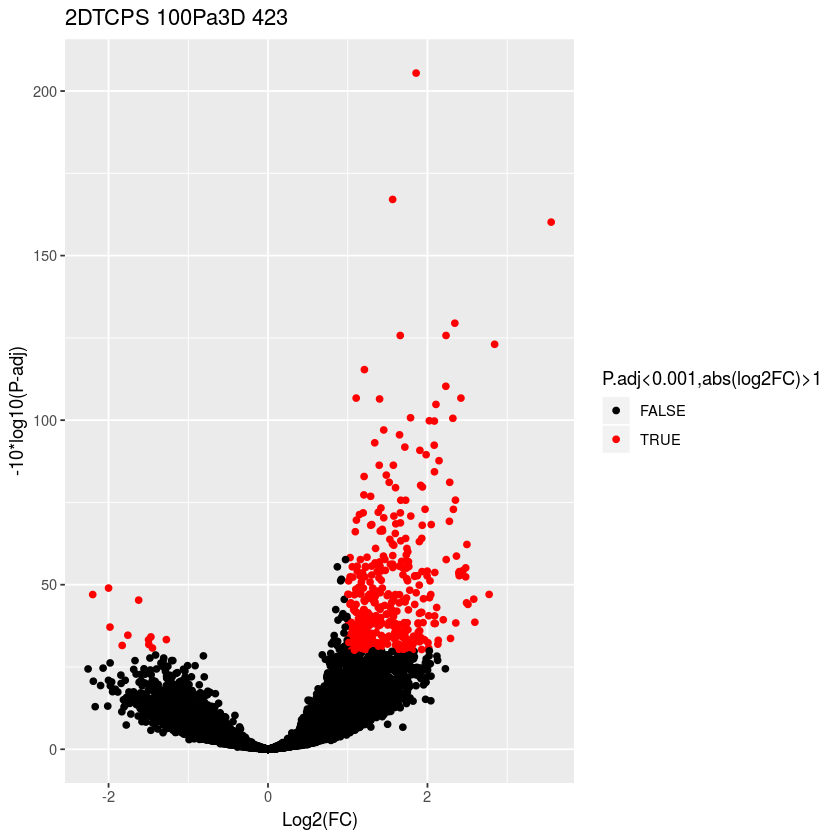

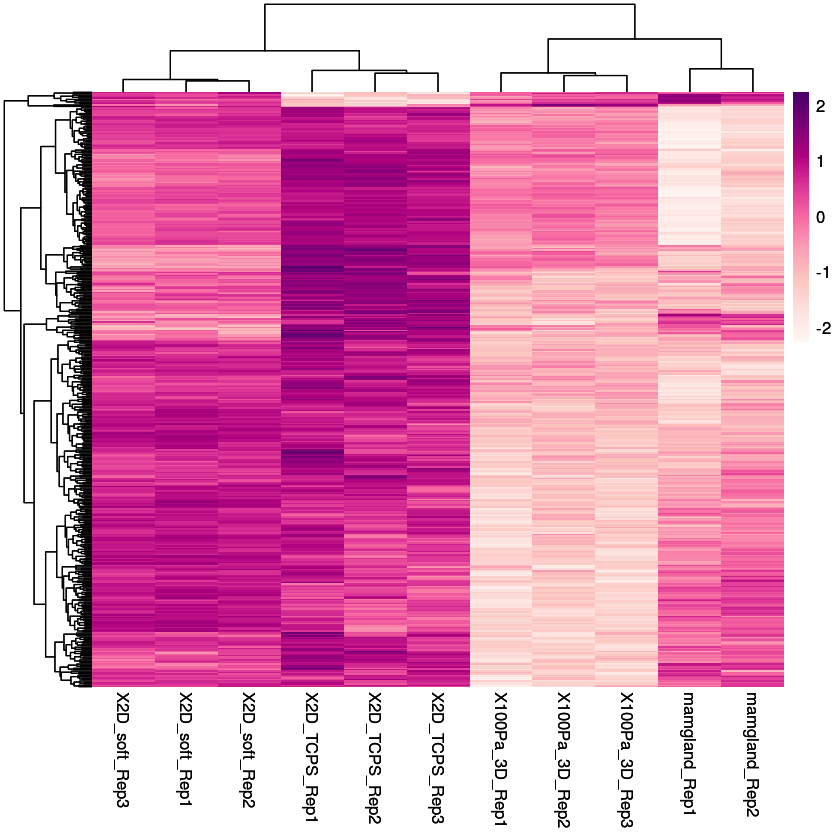

In [29]:
var=c("Sample","Sample","Sample","Sample","Sample","Sample")
s1=c("100Pa3D","2DSoft","2DTCPS","2DSoft","2DSoft","2DTCPS")
s2=c("Mamgland","Mamgland","Mamgland","2DTCPS","100Pa3D","100Pa3D")
numcomparisons=length(var)
for(i in seq(1,numcomparisons))
{
 contrast_inputs=c(var[i],s1[i],s2[i])
 res=results(dds,contrast=contrast_inputs,parallel=TRUE) 
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 sigsubset=res[res$padj<=0.001,]
 sigsubset=sigsubset[abs(sigsubset$log2FoldChange)>1,]
 numsig=nrow(sigsubset)
 print(numsig)
 label=paste(s1[i],s2[i],numsig,sep=' ')

 #generate a volcano plot of the differential analysis for the contrast 
 res$color=(res$padj<=0.001 & abs(res$log2FoldChange)>1)
 print(ggplot(data=res,
 aes(x=res$log2FoldChange,
     y=res$logPadj,
     color=res$color))+
     geom_point()+
xlab("Log2(FC)")+
ylab("-10*log10(P-adj)")+
ggtitle(label)+
scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.001,abs(log2FC)>1"))
    
 #create a heatmap for the 
    ## Heatmap on Transformed Data 
forheatmap=rld[rownames(sigsubset),]

df <- as.data.frame(colData(dds)[,c("Sample")])
ph1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE)
print(ph1)
}


## PCA on normalized counts 

### ntd

In [30]:
data.pca=prcomp(t(log2(normcounts+1)))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [31]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,47.10
2,17.48
3,11.51
4,6.53
5,6.19
6,3.55
7,3.18
8,2.62
9,1.81
10,0.03


In [33]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)


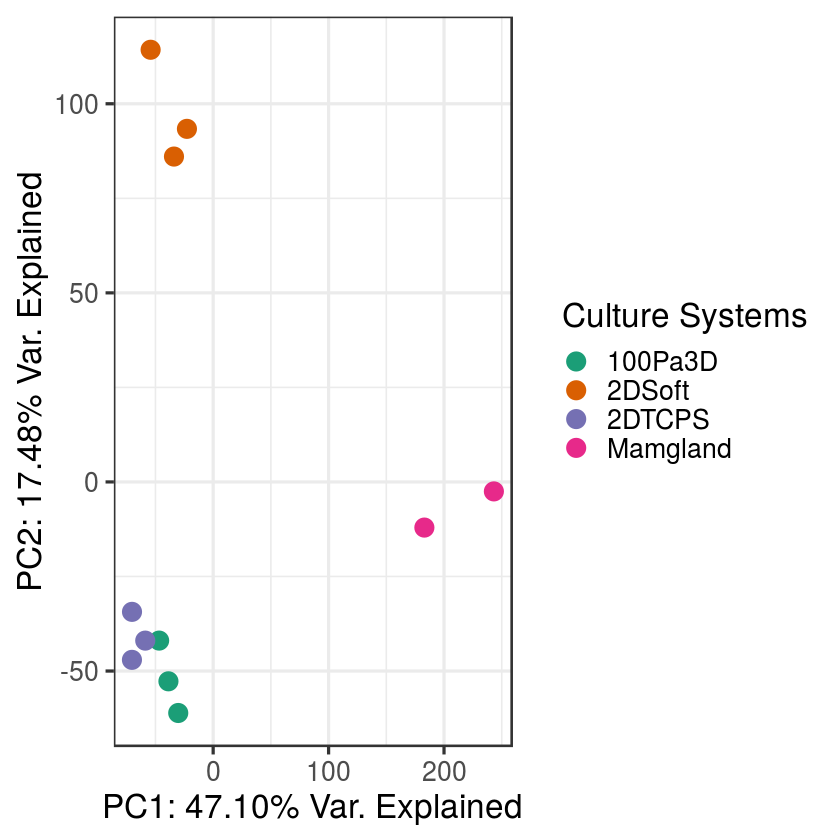

In [34]:
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 47.10% Var. Explained")+
  ylab("PC2: 17.48% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
p1
#svg("pca.svg",width = 8, height = 4, pointsize = 12)
#print(p1)
#dev.off()

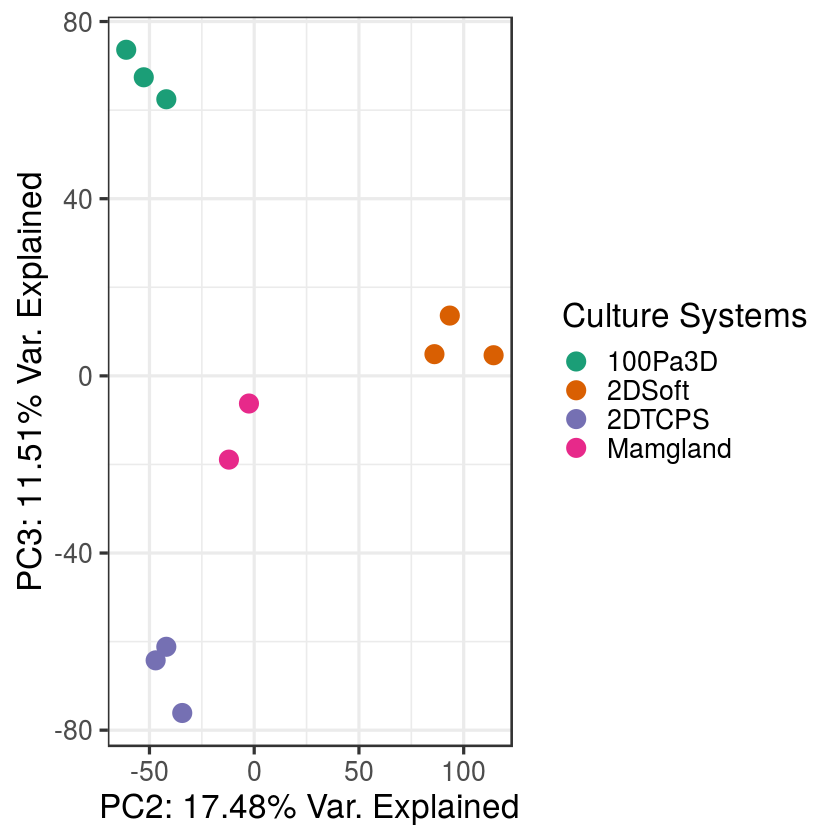

In [35]:
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 17.48% Var. Explained")+
  ylab("PC3: 11.51% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
p2

### VST

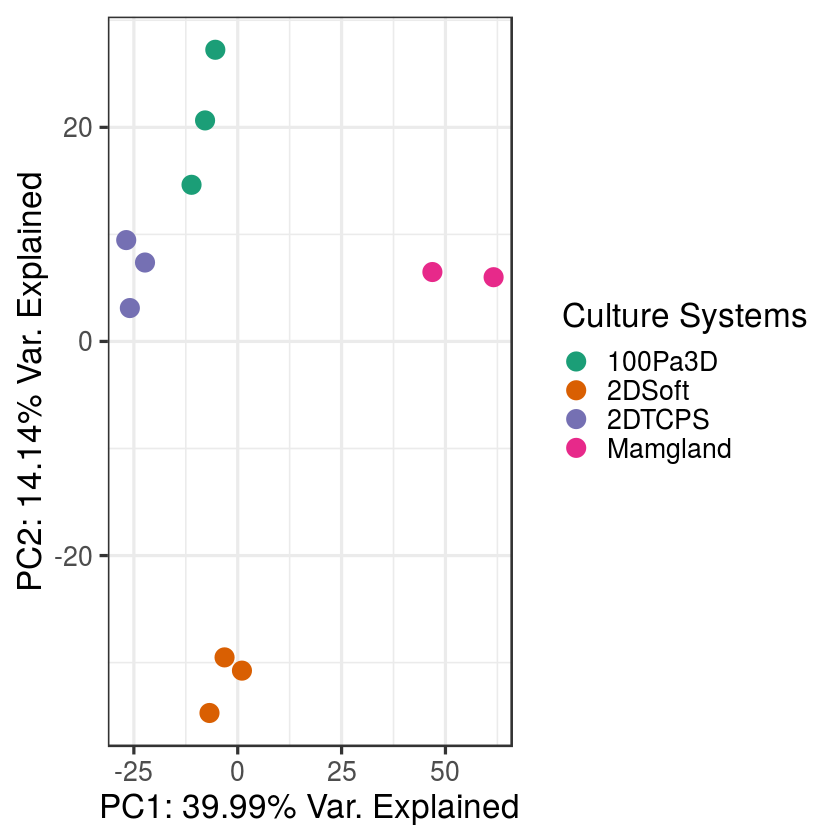

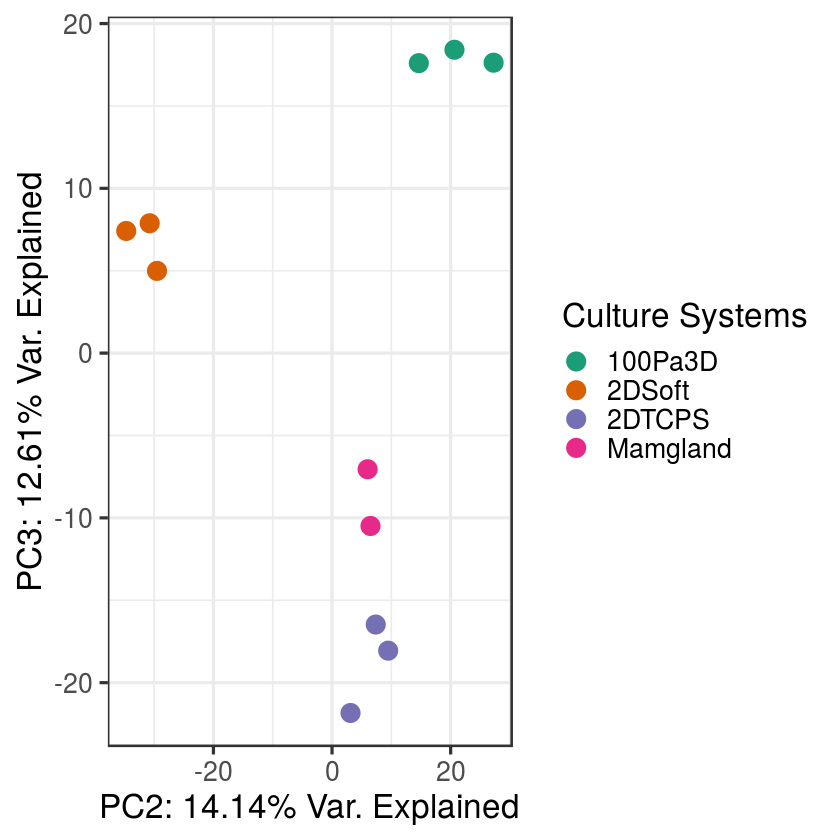

In [36]:
data.pca=prcomp(t(vsd))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 39.99% Var. Explained")+
  ylab("PC2: 14.14% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p1)
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 14.14% Var. Explained")+
  ylab("PC3: 12.61% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p2)

### RLD

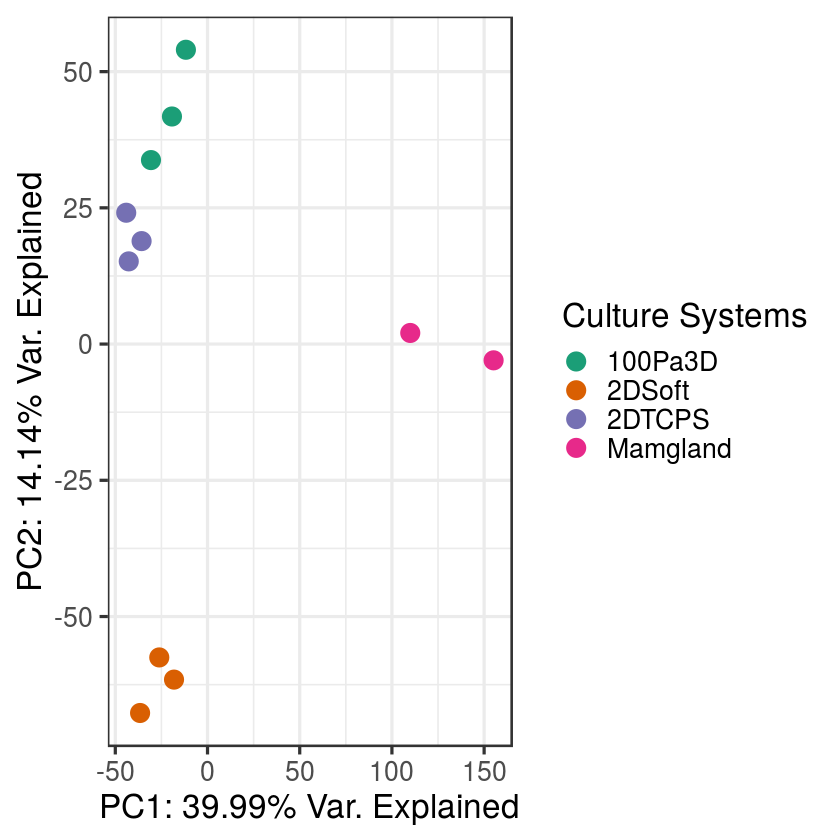

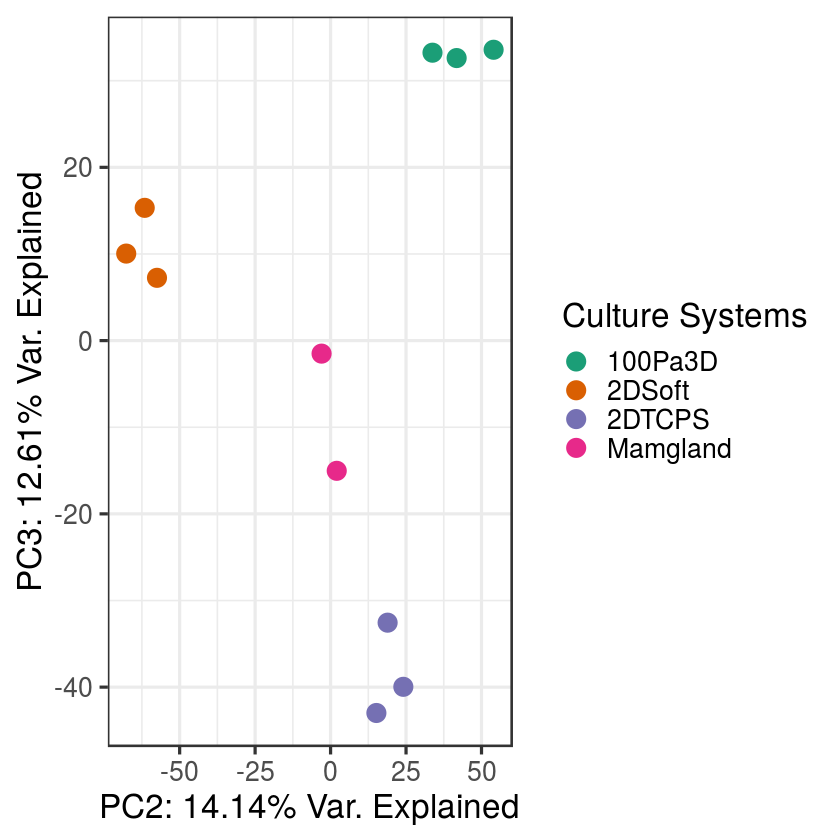

In [37]:
data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 39.99% Var. Explained")+
  ylab("PC2: 14.14% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p1)
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 14.14% Var. Explained")+
  ylab("PC3: 12.61% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p2)